# Notes - race and ethnicity


In [6]:
import duckdb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from graphviz import Digraph
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

In [7]:
con = duckdb.connect("./data/us_births.db", read_only=True)

In [15]:
race_hisp_totals_df = (
    con.execute(
        """
        SELECT 
        mracehisp_c,
        AVG(down_ind) as prob_down_ind,
        AVG(p_ds_lb_nt) as prob_ds_lb_nt,
        AVG(p_ds_lb_wt_mage_reduc) as prob_ds_lb_wt_mage_reduc,
        AVG(ds_case_weight) as prob_ds_case_weight
        FROM us_births
        GROUP BY mracehisp_c;
        """
    )
    .df()
    .dropna()
)

race_hisp_totals_df["mracehisp_c"] = race_hisp_totals_df["mracehisp_c"].map(
    {1: "NH White", 2: "NH Black", 3: "NH AI/AN", 4: "NH Asian/PI", 5: "Hispanic"}
)
race_hisp_totals_df

,mracehisp_c,prob_down_ind,prob_ds_lb_nt,prob_ds_lb_wt_mage_reduc,prob_ds_case_weight
1,NH White,0.000643,0.001873,0.001267,0.001201
2,NH Black,0.000381,0.001581,0.001063,0.001120
3,NH AI/AN,0.000693,0.001422,0.000962,0.001126
4,NH Asian/PI,0.000382,0.002520,0.001675,0.000963
5,Hispanic,0.000567,0.001675,0.001116,0.001399


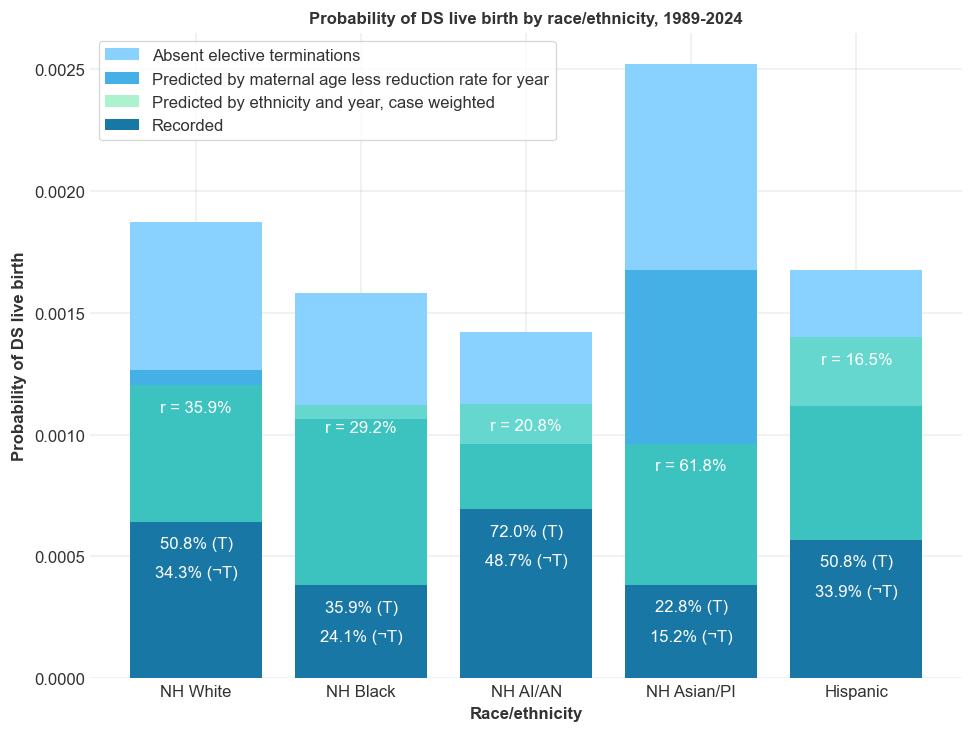

In [32]:
plt.title("Probability of DS live birth by race/ethnicity, 1989-2024")
plt.xlabel("Race/ethnicity")
plt.ylabel("Probability of DS live birth")
plt.bar(
    race_hisp_totals_df["mracehisp_c"],
    race_hisp_totals_df["prob_ds_lb_nt"],
    color="#89d2ff",
    label="Absent elective terminations",
)
plt.bar(
    race_hisp_totals_df["mracehisp_c"],
    race_hisp_totals_df["prob_ds_lb_wt_mage_reduc"],
    color="#45b0e6",
    label="Predicted by maternal age less reduction rate for year",
)
plt.bar(
    race_hisp_totals_df["mracehisp_c"],
    race_hisp_totals_df["prob_ds_case_weight"],
    color="#30e08666",
    label="Predicted by ethnicity and year, case weighted",
)
plt.bar(
    race_hisp_totals_df["mracehisp_c"],
    race_hisp_totals_df["prob_down_ind"],
    color="#1977a6",
    label="Recorded",
)
for i, row in race_hisp_totals_df.iterrows():
    plt.text(
        i - 1,
        row["prob_down_ind"] - 0.00012,
        f"{(row['prob_down_ind'] / row['prob_ds_lb_wt_mage_reduc'] * 100):.1f}% (T)",
        ha="center",
        va="bottom",
        color="white",
    )
for i, row in race_hisp_totals_df.iterrows():
    plt.text(
        i - 1,
        row["prob_down_ind"] - 0.00024,
        f"{(row['prob_down_ind'] / row['prob_ds_lb_nt'] * 100):.1f}% (¬T)",
        ha="center",
        va="bottom",
        color="white",
    )
for i, row in race_hisp_totals_df.iterrows():
    plt.text(
        i - 1,
        row["prob_ds_case_weight"] - 0.00012,
        f"r = {((1 - row['prob_ds_case_weight'] / row['prob_ds_lb_nt']) * 100):.1f}%",
        ha="center",
        va="bottom",
        color="white",
    )
plt.legend()

In [33]:
con.close()